In [ ]:
%whos
%reset -f
%whos

In [1]:
import torch
import torch.nn as nn
import torch.tensor as tensor
import torch.autograd as autograd
import torch.nn.functional as funct
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torchtext.vocab as vocab
from Data.PythonHelperTools.vqaTools.vqa import VQA

import nltk
from PIL import Image
import skimage.io as io

import time
import numpy as np
import os
import copy
import random
import matplotlib.pyplot as plt
import os
import itertools
import operator
from collections import Counter
import re

torch.manual_seed(1)
device = torch.cuda.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class VQA_Dataset(Dataset):
    
    def __init__(self, data_dir="./Data", transform = None, data_sub_type='train2014', num_train_img = 100):
        # From VQA Helper
        self.dataDir = data_dir
        self.transform = transform
        self.num_train_img = num_train_img
        self.versionType ='v2_' # this should be '' when using VQA v2.0 dataset
        self.taskType ='OpenEnded' # 'OpenEnded' only for v2.0. 'OpenEnded' or 'MultipleChoice' for v1.0
        self.dataType ='mscoco'  # 'mscoco' only for v1.0. 'mscoco' for real and 'abstract_v002' for abstract for v1.0.
        self.dataSubType = data_sub_type
        self.annFile ='%s/Annotations/%s%s_%s_annotations.json'%(self.dataDir, self.versionType, self.dataType, self.dataSubType)
        self.quesFile ='%s/Questions/%s%s_%s_%s_questions.json'%(self.dataDir, self.versionType, self.taskType, self.dataType, self.dataSubType)
        self.imgDir = '%s/Images/%s/%s/' %(self.dataDir, self.dataType, self.dataSubType)
        
        # initialize VQA api for QA annotations
        vqa=VQA(self.annFile, self.quesFile)
        annIds = vqa.getQuesIds(quesTypes='how many');
        anns = vqa.loadQA(annIds)
        self.anns_subset = []
        self.Q_and_A = []
        
        for i in range(len(anns)):
            if i<num_train_img:
                self.anns_subset.append(copy.deepcopy(anns[i]))
            elif random.random() < num_train_img/float(i+1):
                replace = random.randint(0, num_train_img-1)
                self.anns_subset[replace] = copy.deepcopy(anns[i])
        
        for i in range(len(self.anns_subset)):
            self.Q_and_A.append(copy.deepcopy(vqa.getQA(self.anns_subset[i])))
        
        self.class_to_int, self.int_to_class = self.init_classes()

    def __len__(self):
        return self.num_train_img
    
    def __get_item__(self, num):
        image = self.get_image(self.anns_subset[num]['image_id'])
        if self.transform is not None:
            image = self.transform(image).unsqueeze_(0)
        question, answers = self.get_QA(num)
        answers = self.most_common(answers)
        answers = tensor(self.get_idx_from_class(answers))
        
        question = nltk.word_tokenize(question)
        pattern = "\?|\!|\."
        prog = re.compile(pattern)
        result = prog.match(question[-1])
        question = question[:-1] if result else question
        
        return (image, question), answers
    
    def init_classes(self):
        class_to_int = {}
        int_to_class = {}
        counter = 0;
        for i in range(self.__len__()):
            answers = self.get_QA(i)[1]
            ans_class = self.most_common(answers)
            if not ans_class in class_to_int:
                class_to_int[ans_class]=counter
                int_to_class[counter] = ans_class
                counter+=1
        return class_to_int, int_to_class
    
    def get_class_len(self):
        return len(self.class_to_int)
    
    def get_class_from_idx(self, idx):
        return self.int_to_class[int(idx.numpy())]
        
    def get_idx_from_class(self, cl):
        return self.class_to_int[cl]
    
    def get_image(self, image_id, type='PIL'):
        imgFilename = 'COCO_' + self.dataSubType + '_'+ str(image_id).zfill(12) + '.jpg'
        image = None
        if os.path.isfile(self.imgDir + imgFilename):
            if type=='ndarray':
                image = io.imread(self.imgDir + imgFilename)
            elif type=='PIL':
                image = Image.open(self.imgDir + imgFilename)
        else:
            print("Error: No Image found.")
        return image
    
    def get_QA(self, num):
        return self.Q_and_A[num]
    
    def show_example(self, num = -1):
        if num==-1:
            num=random.randint(0, self.__len__()-1)
        image = self.get_image(self.anns_subset[num]['image_id'], type = 'ndarray')
        question, answers = self.get_QA(num)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        return num
        
    #from: https://stackoverflow.com/questions/1518522/find-the-most-common-element-in-a-list
    #most_common element in nlog(n)
    def most_common(self, item_list):
        sorted_list = sorted((x, i) for i, x in enumerate(item_list))
        groups = itertools.groupby(sorted_list, key=operator.itemgetter(0))
        
        def _auxfun(g):
            item, iterable = g
            count = 0
            min_index = len(item_list)
            for _, where in iterable:
                count += 1
                min_index = min(min_index, where)
            return count, -min_index
        return max(groups, key=_auxfun)[0]
        

In [3]:
transform = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

vqa_loader = {x: VQA_Dataset(transform=transform, data_sub_type=x) for x in ['train2014']}

loading VQA annotations and questions into memory...
0:00:23.039132
creating index...
index created!


In [13]:
class VQA_Network(nn.Module):

    def __init__(self, num_labels, glove_name='6B', glove_dim='100'):
        super(VQA_Network, self).__init__()
        
        self.num_labels = num_labels
        
        self.image_features = nn.Sequential(*list(models.resnet152(pretrained=True).children())[:-2])        
        self.image_conv = nn.Conv2d(2048, 2048, 1) #dirty TODO: clean
        
        self.conv_lat01 = nn.Conv2d(2048, 512, 1)
        self.drop_lat01 = nn.Dropout2d()
        self.conv_lat02 = nn.Conv2d(512, 1, 1)
        self.softmax_att1 = nn.Softmax(dim=3)

        self.fc1 = nn.Linear(2048*7*7, num_labels)
        self.softmax_lab1 = nn.Softmax(dim=1)
        
        #self.word_embedding = nn.Embedding(num_words, 14*14) #words in vocab, embed dim
        
        self.lstm1 = nn.LSTM(100,2048) #input, output dim
        self.hidden1 = self.init_hidden((2048))

        self.glove = vocab.GloVe(glove_name, glove_dim, cache = "./Word_Embedding")
        print('Loaded {} words'.format(len(self.glove.itos)))
        
        
        self.conv_test = nn.Conv2d(3, 1, 1) #problem testing
        self.fc_test = nn.Linear(224*224, num_labels) #problem testing
        
    def init_hidden(self, hidden_dim):
        return (torch.randn(1,1,hidden_dim), torch.randn(1,1,hidden_dim))
    
    def get_word(self,word):
        return self.glove.vectors[self.glove.stoi[word.lower()]]

    def forward(self, image, q_embed):
        
        if True: #testing reasons
            res_i = self.image_features(image)
            f_i = self.image_conv(res_i)

            f_sub_q, self.hidden1 = self.lstm1(q_embed, self.hidden1)

            f_iq = f_i.squeeze_().transpose(0,2)*torch.sum(f_sub_q, dim=0).squeeze_().expand_as(f_i.squeeze_().transpose(0,2))
            f_iq = f_iq.transpose(0,2).unsqueeze_(0)
            sign_sqrt_f_iq = torch.sqrt(F.relu(f_iq)) - torch.sqrt(F.relu(-f_iq))

            lat_feat_map = self.conv_lat02(self.drop_lat01(F.relu(self.conv_lat01(sign_sqrt_f_iq))))
            norm_lf_map = self.softmax_att1(lat_feat_map)

            w_sum_map = norm_lf_map.squeeze().expand_as(f_i)*f_i

            #label = self.softmax_lab1(self.fc1(norm_lf_map.view(-1))).max(0)
            output = self.fc1(w_sum_map.view(-1).unsqueeze_(0))
            return output

In [26]:
def train_model(model, optimizer, vqa_loader, loss_funct = nn.CrossEntropyLoss(), scheduler = None, num_epochs=25):
    
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print("-"*10)
        
        
        for phase in ['train2014']:
            if phase == 'train2014':
                if not scheduler == None:
                    scheduler.step()
                    model.train()
                else:
                    model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_correct = 0
            
            for i in range(vqa_loader[phase].__len__()):
                inputs, labels = vqa_loader[phase].__get_item__(i)
                image, question = inputs
                #inputs = inputs.to(device)
                #labels = labels.to(device)
                q_embed = vqa_net.get_word(question[0]).unsqueeze_(0).unsqueeze_(0)
                for i in range(len(question)-1):
                    q_embed = torch.cat((q_embed, vqa_net.get_word(question[i+1]).unsqueeze_(0).unsqueeze_(0)))

                labels = labels.unsqueeze_(0) # no minibatch, requires dim tensor [1,C]
                image.requires_grad = True
                q_embed.requires_grad = True
                
                model.hidden1 = model.init_hidden(2048)
                optimizer.zero_grad()
            
                with torch.set_grad_enabled(phase=="true"):

                    outputs = model(image, q_embed)
                    loss = loss_funct(outputs, labels)
                    loss.requires_grad = True
                    

                    if phase == "train2014":
                        loss.backward() #backpropagation
                        optimizer.step() # adjust weights

                #preds = torch.max()
                running_loss += loss.item() #* inputs.size(0)
                #running_correct += torch.sum(preds == labels.data)
            epoch_loss = running_loss/vqa_loader[phase].__len__()
            #epoch_acc = running_correct/vqa_loader[phase].__len__()

            print("{} Loss: {:.4f}, {} Accuracy: {:.4f}").format(phase, epoch_loss, phase, epoch_acc)

            if phase=='val' and epoch_acc < best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model)

        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [27]:
classes = vqa_loader['train2014'].get_class_len()

vqa_net = VQA_Network(num_labels = classes)

Loaded 400000 words


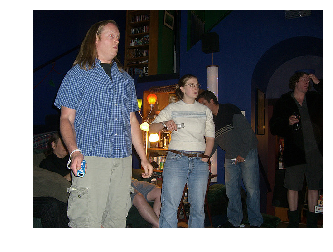

['How', 'many', 'people', 'can', 'be', 'seen']
Answer: 5 Class: 6
tensor([[[[-0.9294, -0.9294, -0.9451,  ..., -0.9608, -0.9373, -0.9608],
          [-0.9451, -0.9451, -0.9529,  ..., -0.9765, -0.9686, -0.9686],
          [-0.9608, -0.9608, -0.9608,  ..., -0.9686, -0.9765, -0.9843],
          ...,
          [-0.8275, -0.8039, -0.8039,  ..., -0.7333, -0.7882, -0.7569],
          [-0.8196, -0.8039, -0.8275,  ..., -0.7490, -0.7647, -0.7098],
          [-0.8118, -0.8275, -0.8353,  ..., -0.7882, -0.7725, -0.6549]],

         [[-0.9216, -0.9216, -0.9373,  ..., -0.9373, -0.9294, -0.9216],
          [-0.9216, -0.9294, -0.9294,  ..., -0.9216, -0.9216, -0.9137],
          [-0.9137, -0.9294, -0.9216,  ..., -0.9216, -0.9137, -0.9294],
          ...,
          [-0.7176, -0.7020, -0.6941,  ..., -0.8039, -0.8431, -0.7412],
          [-0.7176, -0.7098, -0.7176,  ..., -0.8118, -0.7882, -0.7020],
          [-0.7176, -0.7255, -0.7098,  ..., -0.8510, -0.7804, -0.6471]],

         [[-0.8275, -0.8275, -0.8196

In [28]:
#test_examples+
id_num = vqa_loader['train2014'].show_example()

qni, answer = vqa_loader['train2014'].__get_item__(id_num)
image, question = qni[0], qni[1]

print(question)
print("Answer: " + str(vqa_loader['train2014'].get_class_from_idx(answer)) +" Class: "+ str(int(answer.numpy())))
print(image)
word_tensor = vqa_net.get_word(question[2])
print(word_tensor)

In [29]:
train_model(vqa_net, optimizer=optim.Adam(vqa_net.parameters(), lr = 0.0001), vqa_loader = vqa_loader)

Epoch 0/24
----------


KeyError: 'non-felines'